# Hello Object Detection

A very basic introduction to using object detection models with OpenVINO™.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. It detects horizontal text in images and returns a blob of data in the shape of `[100, 5]`. Each detected text box is stored in the `[x_min, y_min, x_max, y_max, conf]` format, where the
`(x_min, y_min)` are the coordinates of the top left bounding box corner, `(x_max, y_max)` are the coordinates of the bottom right bounding box corner and `conf` is the confidence for the predicted class.


#### Table of contents:

- [Imports](#Imports)
- [Download model weights](#Download-model-weights)
- [Select inference device](#Select-inference-device)
- [Load the Model](#Load-the-Model)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)
- [Visualize Results](#Visualize-Results)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/hello-detection/hello-detection.ipynb" />


## Imports
[back to top ⬆️](#Table-of-contents:)


In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from pathlib import Path

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [16]:
def device_widget(default="AUTO", exclude=None, added=None):
    import openvino as ov
    import ipywidgets as widgets

    core = ov.Core()

    supported_devices = core.available_devices + ["AUTO"]
    exclude = exclude or []
    if exclude:
        for ex_device in exclude:
            if ex_device in supported_devices:
                supported_devices.remove(ex_device)

    added = added or []
    if added:
        for add_device in added:
            if add_device not in supported_devices:
                supported_devices.append(add_device)

    device = widgets.Dropdown(
        options=supported_devices,
        value=default,
        description="Device:",
        disabled=False,
    )
    return device

In [17]:
device = device_widget()
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

## Load the Model
[back to top ⬆️](#Table-of-contents:)


In [18]:
core = ov.Core()

model = core.read_model(model='./model/horizontal-text-detection-0001.xml')
compiled_model = core.compile_model(model=model, device_name=device.value)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

## Load an Image
[back to top ⬆️](#Table-of-contents:)


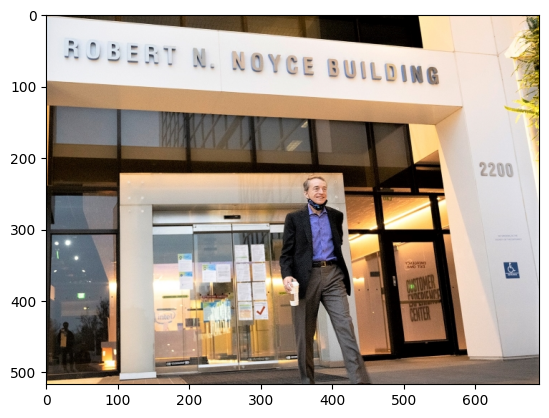

In [20]:
# Text detection models expect an image in BGR format.
image = cv2.imread('./data/intel_rnb.jpg')

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference
[back to top ⬆️](#Table-of-contents:)


In [21]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer_ir]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

## Visualize Results
[back to top ⬆️](#Table-of-contents:)


In [22]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

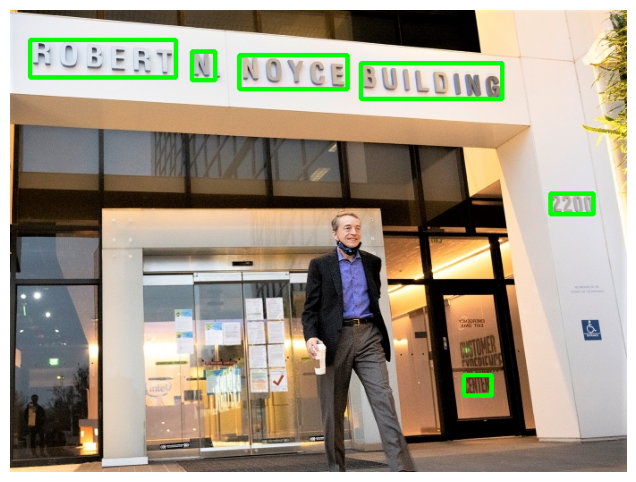

In [23]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));